# PointCloud to Graph Protein Lifting Tutorial

***
This notebook shows how to import UniProt protein data and convert it to a graph using the `PointCloudToGraph` class. Proteins are represented as point clouds where each point is a residue in the protein, setting CarbonAlpha as its centers. The graph is created by connecting residues that are close to each other in the 3D space or that appear in a sequential order.

The target is the mass of each protein.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, creates a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) definding the edges by the following way:
    - **Sequentialwise**: Connecting residues that appear in a sequential order (one after another). This approach is based on the presence of peptide bonds, which link the amino acids in a protein chain in a specific sequence.
    - **KNN**: Connecting residues that are close to each other in the 3D space. This approach is based on the physical proximity of the residues in the protein structure.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a point cloud. 

With this submission, **UniProt** protein dataset is available and loaded as a point cloud, based on PDB files.
***

### Imports and utilities

In [1]:
import sys

sys.path.append("../..")

In [4]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import PointCloudLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the dataset

Here we just need to specify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [5]:
dataset_name = "manual_prot_pointcloud"
dataset_config = load_dataset_config(dataset_name)
loader = PointCloudLoader(dataset_config)


Dataset configuration for manual_prot_pointcloud:

{'data_domain': 'pointcloud',
 'data_type': 'toy_dataset',
 'data_name': 'manual_prot',
 'data_dir': 'datasets/pointcloud/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:

In [6]:
dataset = loader.load()

## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data. For this example the knn lifting was chosen. The algorithm takes the k nearest neighbors for each node and creates a hyperedge with them. Moreover, the algorithm also creates an edge for each sequential pair of residues.


In [7]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "pointcloud2graph/knn_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for pointcloud2graph/knn_lifting:

{'transform_type': 'lifting',
 'transform_name': 'PointCloudKNNLifting',
 'max_cell_length': None,
 'preserve_edge_attr': False,
 'feature_lifting': 'None',
 'k_value': 10,
 'loop': False}


We than apply the transform via our `PreProcesor`:

Transform parameters are the same, using existing data_dir: /home/bmiquel/Documents/Projects/Topo/challenge-icml-2024/datasets/pointcloud/toy_dataset/manual_prot/lifting/2528556562

Dataset only contains 1 sample:


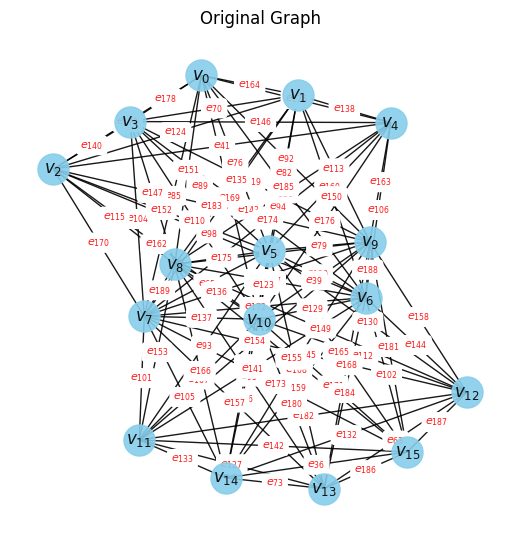

 - Graph with 16 vertices and 190 edges.
 - Features dimensions: [20, 0]
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4,  4,  5,
          8,  5,  8, 10,  0, 11, 11, 13, 15,  6,  7,  6,  7,  4,  3,  5,  8,  9,
         14,  5,  8,  9,  0,  2, 11,  1, 13,  6, 15,  7,  6,  7,  3, 14,  8,  9,
          5,  9,  0, 11,  1, 15,  7,  7,  3, 12,  3,  5, 14,  9,  0,  9,  1, 13,
         10, 13, 15, 12,  5, 12, 14,  5,  9, 10,  1, 13,  6,  7, 15,  7, 12,  3,
          5, 14,  9,  5, 10,  8,  1, 13,  2, 15,  7,  7,  6, 12,  3, 14,  4,  9,
          5,  8, 10,  8, 10,  1, 13,  2,  7,  6,  3,  3,  5,  4, 14, 10,  1,  0,
         10, 11,  2,  6, 12,  4, 12, 14,  4,  8,  8, 10,  1,  0,  2, 11, 11,  6,
          6, 12,  3,  8, 10,  8,  1,  0,  2, 11,  9, 15,  6,  7, 12, 14,  4,  8,
         10,  9,  0,  5,  8, 10,  9,  0,  2, 15,  6,  7,  4,  5, 10,  9,  0,  2,
         10,  9, 11,  2, 13,  6, 13, 15,  6,  7],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15

In [8]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

In [11]:
lifted_dataset[0].edge_index.to_dense()

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4,  4,  5,
          8,  5,  8, 10,  0, 11, 11, 13, 15,  6,  7,  6,  7,  4,  3,  5,  8,  9,
         14,  5,  8,  9,  0,  2, 11,  1, 13,  6, 15,  7,  6,  7,  3, 14,  8,  9,
          5,  9,  0, 11,  1, 15,  7,  7,  3, 12,  3,  5, 14,  9,  0,  9,  1, 13,
         10, 13, 15, 12,  5, 12, 14,  5,  9, 10,  1, 13,  6,  7, 15,  7, 12,  3,
          5, 14,  9,  5, 10,  8,  1, 13,  2, 15,  7,  7,  6, 12,  3, 14,  4,  9,
          5,  8, 10,  8, 10,  1, 13,  2,  7,  6,  3,  3,  5,  4, 14, 10,  1,  0,
         10, 11,  2,  6, 12,  4, 12, 14,  4,  8,  8, 10,  1,  0,  2, 11, 11,  6,
          6, 12,  3,  8, 10,  8,  1,  0,  2, 11,  9, 15,  6,  7, 12, 14,  4,  8,
         10,  9,  0,  5,  8, 10,  9,  0,  2, 15,  6,  7,  4,  5, 10,  9,  0,  2,
         10,  9, 11,  2, 13,  6, 13, 15,  6,  7],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  9,  1,
          0, 10,  9,  6,  5,  5, 14,  8,  5,  2,  1, 11, 10

## Create and Run a Cell NN Model

In this section a simple model is created to test that the used lifting works as intended. A graph neural network from torch_geometric is used.

In [9]:
from modules.models.graph.graphsage import GraphSAGEModel

model_type = "graph"
model_id = "graphsage"
model_config = load_model_config(model_type, model_id)

model = GraphSAGEModel(model_config, dataset_config)


Model configuration for graph GRAPHSAGE:

{'in_channels_0': None,
 'in_channels_1': None,
 'in_channels_2': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2}


In [10]:
y_hat = model(lifted_dataset.get(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x20 and 1x32)

If everything is correct the cell above should execute without errors. 